# Clone from github

In [ ]:
!git clone https://github.com/jveenland/TM10007_ML_Project.git

Cloning into 'TM10007_ML_Project'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 87 (delta 9), reused 8 (delta 8), pack-reused 73
Receiving objects: 100% (87/87), 67.99 MiB | 41.17 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [ ]:
# Navigeer naar de juiste map
%cd /content/TM10007_ML_Project

# Voer setup.py uit
!python3 setup.py

%cd /content/TM10007_ML_Project/worcgist
!python load_data.py

/content/TM10007_ML_Project
usage: setup.py [global_opts] cmd1 [cmd1_opts] [cmd2 [cmd2_opts] ...]
   or: setup.py --help [cmd1 cmd2 ...]
   or: setup.py --help-commands
   or: setup.py cmd --help

error: no commands supplied
/content/TM10007_ML_Project/worcgist


# Load data


In [ ]:
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git


# Data loading functions. Uncomment the one you want to use
from worcgist.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')


  Preparing metadata (setup.py) ... done
The number of samples: 246
The number of columns: 494


# Load packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_learning_curve

# Inspect data

In [ ]:
# Dataframe, shape en beschrijving (mean, std etc van alle features)
data = pd.read_csv('GIST_radiomicFeatures.csv')
#print(data)
print(data.shape)
#print(data.describe())

(246, 495)


# Process data

In [ ]:
# Process data
values = np.where(data['label'] == 'GIST', 1, 0)
X = data.iloc[:, 2:].values
y = np.array(values)

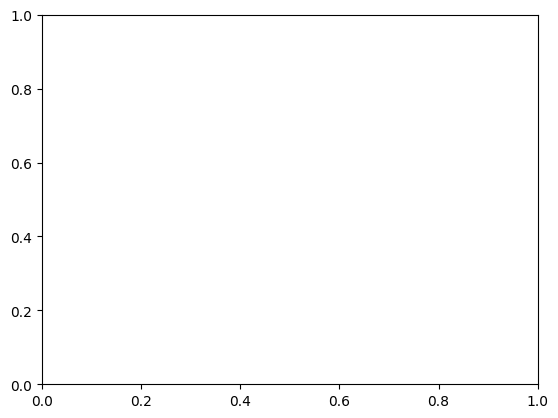

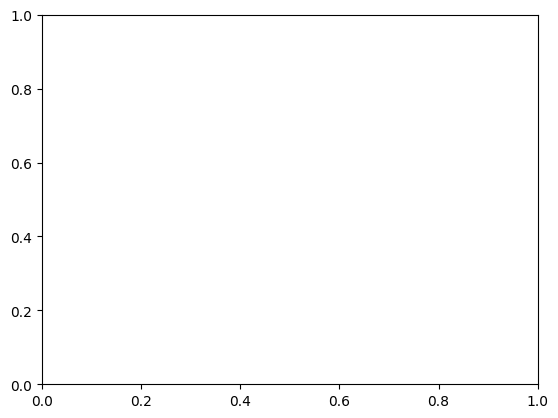

# Apply classifiers and feature selectors

In [ ]:
%matplotlib notebook
# Define classifiers and feature selectors
classifiers = [KNeighborsClassifier(), RandomForestClassifier(), SVC(gamma='scale')]
feature_selectors = [PCA(n_components=0.9), SelectKBest(f_regression, k=15)]
RF_counter = 0

# Create figures
fig_test, ax_test = plt.subplots()
fig_train, ax_train = plt.subplots()

# Iterate over classifiers and feature selectors
for classifier in classifiers:
    for feature_selector in feature_selectors:
        if RF_counter > 0 and isinstance(classifier, RandomForestClassifier):
            continue
        mean_fpr = np.linspace(0, 1, 100)
        tprs = []
        aucs = []
        accus = []

        # Initialize lists for training data
        tprs_train = []
        aucs_train = []
        accus_train = []

        # Perform multiple iterations
        for i in range(1):
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=y)

            # Scale data
            scaler = preprocessing.MinMaxScaler()
            scaler.fit(X)
            X_train_scaled = scaler.transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            # Fit feature selector
            if isinstance(feature_selector, SelectKBest):
                feature_selector.fit(X_train_scaled, y_train)
            elif not isinstance(classifier, RandomForestClassifier):
                feature_selector.fit(X_train_scaled)

            # Transform features
            if isinstance(classifier, RandomForestClassifier):
                X_train_feature = X_train_scaled
                X_test_feature = X_test_scaled
            else:
                X_train_feature = feature_selector.transform(X_train_scaled)
                X_test_feature = feature_selector.transform(X_test_scaled)

            # Define parameters for grid search
            if isinstance(classifier, KNeighborsClassifier):
                parameters = {"n_neighbors": list(range(1, 42, 2))}
            elif isinstance(classifier, RandomForestClassifier):
                parameters = {"n_estimators": list(range(100, 2000, 100))}
            elif isinstance(classifier, SVC):
                parameters = {
                    "degree": [1, 3, 5],
                    "coef0": [0.01, 0.5, 1],
                    "C": [0.01, 0.5, 1],
                    "kernel": ['linear', 'poly']
                }

            # Perform grid search
            cv_10 = StratifiedKFold(n_splits=5)
            grid_search = GridSearchCV(classifier, parameters, cv=cv_10, scoring='accuracy')
            grid_search.fit(X_train_feature, y_train)

            # Get best parameters
            if isinstance(classifier, KNeighborsClassifier):
                best_params = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'])
            elif isinstance(classifier, RandomForestClassifier):
                best_params = RandomForestClassifier(n_estimators=grid_search.best_params_['n_estimators'])
            elif isinstance(classifier, SVC):
                best_params = SVC(kernel=grid_search.best_params_['kernel'], degree=grid_search.best_params_['degree'], coef0=grid_search.best_params_['coef0'], C=grid_search.best_params_['C'], gamma='scale')

            # Calculate accuracy
            best_params.fit(X_train_feature, y_train)
            predictions = best_params.predict(X_test_feature)
            accu = accuracy_score(y_test, predictions)
            accus.append(accu)

            predictions_train = best_params.predict(X_train_feature)
            accu_train = accuracy_score(y_train, predictions_train)
            accus_train.append(accu_train)

            # Calculate ROC curve and AUC for test data
            if isinstance(classifier, SVC):
                distances = best_params.decision_function(X_test_feature)
                logistic_model = LogisticRegression()
                logistic_model.fit(distances.reshape(-1,1), y_test)
                svm_probabilities = logistic_model.predict_proba(distances.reshape(-1,1))
                fpr, tpr, _ = roc_curve(y_test, svm_probabilities[:,1])
            else:
                class_probabilities = best_params.predict_proba(X_test_feature)
                preds = class_probabilities[:, 1]
                fpr, tpr, _ = roc_curve(y_test, preds)

            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)

            # Calculate ROC curve and AUC for train data
            if isinstance(classifier, SVC):
                distances_train = best_params.decision_function(X_train_feature)
                logistic_model_train = LogisticRegression()
                logistic_model_train.fit(distances_train.reshape(-1,1), y_train)
                svm_probabilities_train = logistic_model_train.predict_proba(distances_train.reshape(-1,1))
                fpr_train, tpr_train, _ = roc_curve(y_train, svm_probabilities_train[:,1])
            else:
                class_probabilities_train = best_params.predict_proba(X_train_feature)
                preds_train = class_probabilities_train[:, 1]
                fpr_train, tpr_train, _ = roc_curve(y_train, preds_train)

            roc_auc_train = auc(fpr_train, tpr_train)
            aucs_train.append(roc_auc_train)
            interp_tpr_train = np.interp(mean_fpr, fpr_train, tpr_train)
            interp_tpr_train[0] = 0.0
            tprs_train.append(interp_tpr_train)

        # Caclulate mean accuracy
        mean_accu = np.mean(accus)
        mean_accu_train = np.mean(accus_train)

        print(f"Accuracy of {classifier} & {feature_selector}:")
        print(f"Train: {mean_accu_train}")
        print(f"Test: {mean_accu}")
        print("------------------------------------------------------------------")


        # Calculate mean true positive rate and false positive rate across all iterations
        mean_tpr = np.mean(tprs, axis=0)
        mean_auc = np.mean(aucs)

        # Plot ROC curve and AUC for test data
        ax_test.plot(mean_fpr, mean_tpr, label=f"{classifier} & {feature_selector} (AUC = {mean_auc:.2f})")

        # Repeat the process for training data
        mean_tpr_train = np.mean(tprs_train, axis=0)
        mean_auc_train = np.mean(aucs_train)

        ax_train.plot(mean_fpr, mean_tpr_train, label=f"{classifier} & {feature_selector} (AUC = {mean_auc_train:.2f})")

        if isinstance(classifier, RandomForestClassifier):
            RF_counter += 1

# Add legend and title to the test plot
ax_test.set_xlabel("False Positive Rate")
ax_test.set_ylabel("True Positive Rate")
ax_test.legend(loc="best")
ax_test.set_title("ROC Curve and AUC for Test Data")

# Add legend and title to the train plot
ax_train.set_xlabel("False Positive Rate")
ax_train.set_ylabel("True Positive Rate")
ax_train.legend(loc="best")
ax_train.set_title("ROC Curve and AUC for Training Data")

# Display figures
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Accuracy of KNeighborsClassifier() & PCA(n_components=0.9):
Train: 0.8197674418604651
Test: 0.527027027027027
------------------------------------------------------------------
Accuracy of KNeighborsClassifier() & SelectKBest(k=15, score_func=<function f_regression at 0x7df4a3356290>):
Train: 0.6744186046511628
Test: 0.581081081081081
------------------------------------------------------------------
Accuracy of RandomForestClassifier() & PCA(n_components=0.9):
Train: 1.0
Test: 0.581081081081081
------------------------------------------------------------------
Accuracy of SVC() & PCA(n_components=0.9):
Train: 0.6162790697674418
Test: 0.6351351351351351
------------------------------------------------------------------
Accuracy of SVC() & SelectKBest(k=15, score_func=<function f_regression at 0x7df4a3356290>):
Train: 0.7034883720930233
Test: 0.6081081081081081
------------------------------------------------------------------


# Display learning curves

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, classifier in zip(axes, classifiers):
    display = LearningCurveDisplay.from_estimator(classifier, X, y)
    display.plot(ax=ax)
    ax.set_title(type(classifier).__name__)

plt.tight_layout()
plt.show()

ImportError: cannot import name 'plot_learning_curve' from 'sklearn.metrics' (/usr/local/lib/python3.10/dist-packages/sklearn/metrics/__init__.py)